# Brain MRI segmentation
---

In [ ]:
cat ../input/lgg-mri-segmentation/kaggle_3m/README.md

### Imports

In [6]:
from   datetime import datetime
from   functools import reduce
import os
from   pathlib import Path
import re

import cv2 as cv
import torch
import torch.nn as nn
import torch.optim as optim
from   torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torchvision.transforms.functional as F
from   torchvision.utils import make_grid, draw_segmentation_masks
from   matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   PIL import Image
import plotly.express as px
from   scipy.ndimage.morphology import binary_dilation
from   skimage import io
from   sklearn.model_selection import train_test_split

from   torchmetrics import JaccardIndex, Dice
from   sklearn.metrics import jaccard_score

# bon exemple : TCGA_DU_7306
# bon aussi car moins dexemple : TCGA_CS_5393

pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', 50)

### Helpers

In [7]:
def imread(path, mode=cv.IMREAD_UNCHANGED):
    return cv.imread(str(path), mode) / 255

def mask_to_contour(mask, thickness=1, color="red"):
    """Returns contour of binary black and white mask."""
    assert mask.ndim == 3, "Mask is not RGB."
    assert mask.dtype == np.float64, "Make sure mask is in the range [0-1]."
    contour = reduce(lambda x, _: binary_dilation(x), [mask]*(thickness+1)) - mask
    return contour * colors.to_rgb(color)

def colored_mask(mask, color="red"):
    """Converts a black and white mask to a colored one."""
    assert mask.ndim == 3, "Mask is not RGB."
    assert mask.dtype == np.float64, "Make sure mask is in the range [0-1]."
    return mask * colors.to_rgb(color)

# def apply_mask(img, mask, alpha=.6):
#     """Apply a mask to an image."""
#     assert img.ndim == mask.ndim == 3, "Make sur img and mask are RGB."
#     assert img.dtype == mask.dtype == np.float64, "Make sure img and mask are in the range [0-1]."
#     f = np.any(mask, axis=2)
#     t = np.stack((f,)*3, axis=-1)
#     u = np.copy(img)
#     temp = u + alpha * (mask - u)
#     u[t] = temp[t]
#     return u

def apply_mask(img, mask, thickness=None, alpha=None , color="red"):
    """mode = contour or patch"""
    assert img.ndim == mask.ndim == 3, "Make sur img and mask are RGB."
    assert img.dtype == mask.dtype == np.float64, "Make sure img and mask are in the range [0-1]."
    new_mask = np.copy(mask)
    if thickness:
        new_mask = reduce(lambda x, _: binary_dilation(x), [mask]*(thickness+1)) - mask
    new_mask *= colors.to_rgb(color)
    f = np.any(mask, axis=2)
    t = np.stack((f,)*3, axis=-1)
    u = np.copy(img)
    if alpha:
        new_mask = u + alpha * (new_mask - u)
    u[t] = new_mask[t]
    return u

### Dataset analysis

In [8]:
data_path = Path('../input/lgg-mri-segmentation/kaggle_3m/')

# patients info
data_csv = pd.read_csv(data_path/"data.csv")

# dataset as pandas dataframe
data_pd = pd.DataFrame([
    (path.parts[-2], Path(str(path).replace("_mask", '')), path)
    for path in sorted(data_path.rglob("*_mask.tif"),
                       key=lambda a: ''.join(map(lambda x: f"{x:0>2}", re.split(r'_', a.stem))))
], columns=["patient", "image", "mask"])

### Visualization

In [ ]:
def imread2(path):
    return cv.imread(str(path)) / 255

# select random patient
patient = np.random.choice(data_pd["patient"].unique())

# retrieve paths for the scans and masks of the patient
_, imgs_path, masks_path = data_pd[data_pd["patient"] == patient].T.to_numpy()

# read images and masks into a list of tuples
samples = [(imread2(img), imread2(mask)) for img,mask in zip(imgs_path, masks_path)]

# list of merged image and mask next to mask
segs = np.array([np.hstack((apply_mask(img, mask, alpha=.4), mask)) for img,mask in samples])

# create slideshow
fig = px.imshow(segs, animation_frame=0, binary_string=True, labels=dict(animation_frame="slice"))
fig.update_layout(xaxis_showticklabels=False, yaxis_showticklabels=False)

# display patient info and mri
display(data_csv.loc[data_csv['Patient'] == patient[:12]])
fig.show()

### Dataset

In [9]:
class BrainDataset(Dataset):
    def __init__(self, df, transform=None):
        super(BrainDataset, self).__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        _, image_path, mask_path = self.df.iloc[idx]
#         image = imread(image_path)
#         mask = imread(mask_path, mode=cv.IMREAD_GRAYSCALE)
        image = io.imread(image_path)
        mask = io.imread(mask_path)
        if self.transform:
            image, mask = self.transform(image), self.transform(mask)
        return image, mask

In [61]:
# train_data, val_data, test_data = random_split(data, [.75, .15, .10], generator=torch.Generator().manual_seed(0))

train_df, temp_df = train_test_split(data_pd, test_size=.25)
val_df, test_df = train_test_split(temp_df, test_size=.4)

train_transform = T.Compose([T.ToTensor(),])
eval_transform = T.ToTensor()

train_data = BrainDataset(train_df, transform=train_transform)
val_data = BrainDataset(val_df, transform=eval_transform)
test_data = BrainDataset(test_df, transform=eval_transform)

train_loader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=2,
)

val_loader = DataLoader(
    val_data,
    batch_size=32,
    shuffle=False,
    num_workers=2,
)

test_loader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
    num_workers=2,
)

In [22]:
epochs = 20
model_name = "unet"
device = torch.device("cuda")
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [23]:
def train_loop(dataloader, optimizer, loss_fn, epoch):
    train_loss = 0
    model.train()
    for batch, (image, mask) in enumerate(dataloader):
        print(f"[Epoch {epoch:>2}] Train batch progress: {batch+1:>3}/{len(dataloader)}", end='\r')
        image = image.to(device)
        mask = mask.to(device)
        output = model(image)
        loss = loss_fn(output, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * image.size(0)
#         break
    return train_loss / len(dataloader.dataset)

def eval_loop(dataloader, optimizer, loss_fn, epoch):
    val_loss = 0
    iou = 0
#     jaccard = JaccardIndex(task="binary", num_classes=2).to(device)
    dice = 0
#     dice = Dice(average='micro').to(device)
    len_loader = len(dataloader.dataset)
    model.eval()
    with torch.no_grad():
        for batch, (image, mask) in enumerate(dataloader):
            print(f"[Epoch {epoch:>2}] Val batch progress: {batch+1:>3}/{len(dataloader)}  ", end='\r')
            image = image.to(device)
            mask = mask.to(device)
            output = model(image)
            
            val_loss += loss_fn(output, mask).item() * image.size(0)
            output = (output > .5).float()
            iou += jaccard_score(mask.cpu().flatten(), output.cpu().flatten(), zero_division=1.0) * image.size(0)
#             break
    return (val_loss/len_loader, iou/len_loader, dice/len_loader)

### Training

In [24]:
for epoch in range(1, epochs+1):
    train_loss = train_loop(train_loader, optimizer, loss_fn, epoch)
    val_loss, iou, dice = eval_loop(val_loader, optimizer, loss_fn, epoch)
    print(f"[Epoch {epoch:>2}] Train loss: {train_loss:.5f} | Val loss: {val_loss:.5f} | Val IoU: {iou:.2%} | Val Dice:")
torch.save(model.state_dict(), model_name+'_'+datetime.now().strftime("%Y%m%d-%H%M%S")+'.pth')

[Epoch  1] Train loss: 0.03410 | Val loss: 0.03591 | Val IoU: 33.46% | Val Dice:
[Epoch  2] Train loss: 0.02081 | Val loss: 0.01996 | Val IoU: 41.94% | Val Dice:
[Epoch  3] Train loss: 0.01876 | Val loss: 0.02686 | Val IoU: 40.64% | Val Dice:
[Epoch  4] Train loss: 0.01738 | Val loss: 0.02866 | Val IoU: 37.11% | Val Dice:
[Epoch  5] Train loss: 0.01709 | Val loss: 0.01967 | Val IoU: 48.12% | Val Dice:
[Epoch  6] Train loss: 0.01640 | Val loss: 0.01782 | Val IoU: 49.51% | Val Dice:
[Epoch  7] Train loss: 0.01511 | Val loss: 0.01774 | Val IoU: 46.86% | Val Dice:
[Epoch  8] Train loss: 0.01399 | Val loss: 0.01365 | Val IoU: 57.50% | Val Dice:
[Epoch  9] Train loss: 0.01281 | Val loss: 0.02087 | Val IoU: 39.21% | Val Dice:
[Epoch 10] Train loss: 0.01247 | Val loss: 0.01773 | Val IoU: 56.95% | Val Dice:
[Epoch 11] Train loss: 0.01139 | Val loss: 0.01072 | Val IoU: 64.52% | Val Dice:
[Epoch 12] Train loss: 0.01130 | Val loss: 0.01088 | Val IoU: 61.08% | Val Dice:
[Epoch 13] Train loss: 0.010

tensor(0.0157)


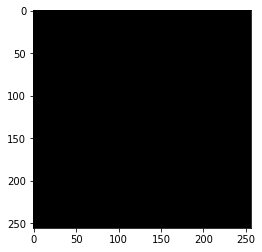

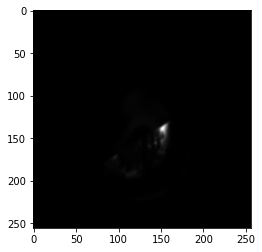

In [56]:
img,mask = next(iter(test_loader))
print(torch.max(img[0][0][0]))
img = img[0].unsqueeze(0)
model.to("cpu")
res = model(img)
res = res[0].permute((1,2,0))
res = res.detach().numpy()
mask = mask[0].permute((1,2,0)).detach().numpy()
plt.imshow(mask, cmap="gray")
plt.show()
plt.imshow(res, cmap="gray")

In [ ]:
img = cv.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif')
mask = cv.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif')
# mask2 = cv.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16_mask.tif')
print("cv", mask.shape)
print("io", mask2.shape)

# a = mask_to_contour(mask/255, thickness=1)
# a = colored_mask(mask/255, color="red")
# a = apply_mask(mask/255, mask_to_contour(mask2/255, thickness=3), alpha=.6)
# a = apply_mask(mask/255, colored_mask(mask2/255), alpha=.5)
a = apply_mask(img/255, colored_mask(mask/255), alpha=.7)
# plt.imshow(mask)
# plt.show()
plt.imshow(a)
plt.show()
# plt.imshow(mask)
# plt.show()